# Code Review II - Estimate HSIC

This notebook features all of the functions necessary to estimate HSIC **given** different sigma estimation methods. We will look at the 3 methods:

* HSIC (centered kernel, unnormalized)
* Centered Kernel Alignment (CKA) (centered kernel, normalized)
* Kernel Alignment (KA) (uncentered kernel, unnormalized)

And we will also look at how we calculate the kernel matrix:

* 1 RBF Kernel for both $K_{XY}$
* 1 RBF Kernel per datasets, $K_X, K_Y$
* 1 ARD Kernel per dataset, $K_{X_d}, K_{Y_d}$ (an RBF kernel with a lengths scale per dimensions)

In [1]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

import numpy as np
import pandas as pd
from functools import partial

# toy datasets
from data.distribution import DataParams, Inputs

# Plotting Procedures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-paper'])

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

ModuleNotFoundError: No module named 'data'

## Data

In [ ]:
def plot_2d_data(X):
    fig  = plt.figure()

    g = sns.jointplot(
        x=X[:, 0],
        y=X[:, 1],
    )
    plt.tight_layout()
    plt.show()
    
def plot_1d_data(X):
    fig, ax = plt.subplots()
    ax.hist(X)
    
# initialize the data generator
dist_data = DataParams(
    dataset='tstudent',
    trial=1,
    std=2,
    nu=7,
    samples=500,
    dimensions=2
)
inputs = dist_data.generate_data()

# Plot the Distribution
plot_1d_data(inputs.X[:, 0])
plot_1d_data(inputs.X[:, 1])

## Estimate Sigma

I'll be using the same function that I developed in the last notebook which had the following methods available:



In [ ]:
from typing import Optional
from scipy.spatial.distance import pdist, squareform

def scotts_factor(X: np.ndarray) -> float:
    """Scotts Method to estimate the length scale of the 
    rbf kernel.
    
        factor = n**(-1./(d+4))
    
    Parameters
    ----------
    X : np.ndarry
        Input array
    
    Returns
    -------
    factor : float
        the length scale estimated
    
    """
    n_samples, n_features = X.shape
    
    return np.power(n_samples, - 1 / (n_features + 4.))

def silvermans_factor(X: np.ndarray) -> float:
    """Silvermans method used to estimate the length scale
    of the rbf kernel.
    
    factor = (n * (d + 2) / 4.)**(-1. / (d + 4)).
    
    Parameters
    ----------
    X : np.ndarray,
        Input array
    
    Returns
    -------
    factor : float
        the length scale estimated
    """
    n_samples, n_features = X.shape
    
    base = ( n_samples * (n_features + 2.) ) / 4.
    
    return np.power(base, - 1 / (n_features + 4.))

def kth_distance(dists: np.ndarray, percent: float) -> np.ndarray:
    
    # kth distance calculation (50%)
    kth_sample = int(percent * dists.shape[0])
    
    # take the Kth neighbours of that distance
    k_dist = dists[:, kth_sample]
    
    return k_dist

def sigma_estimate(
    X: np.ndarray,
    method: str='median',
    percent: Optional[int]=None,
    heuristic: bool=False
) -> float:
    
    # get the squared euclidean distances
    if method == 'silverman':
        return silvermans_factor(X)
    elif method == 'scott':
        return scotts_factor(X)
    elif percent is not None:
        kth_sample = int((percent/100) * X.shape[0])
        dists = np.sort(squareform(pdist(X, 'sqeuclidean')))[:, kth_sample]
#         print(dists.shape, dists.min(), dists.max())
    else:
        dists = np.sort(pdist(X, 'sqeuclidean'))
#         print(dists.shape, dists.min(), dists.max())
        
    
    if method == 'median':
        sigma = np.median(dists)
    elif method == 'mean':
        sigma = np.mean(dists)
    else:
        raise ValueError(f"Unrecognized distance measure: {method}")
    
    if heuristic:
        sigma = np.sqrt(sigma / 2)
    return sigma

## RBF Kernel Matrix

We define the generalized RBF kernel like so:

$$
K(\mathbf{x,y}) = \exp\left(-\frac{1}{2}\left|\left|\frac{\mathbf{x}}{\sigma} - \frac{\mathbf{y}}{\sigma}\right|\right|^2_2\right)
$$

where $\mathbf{x,y} \in \mathbb{R}^{D}$ and $\sigma$ can be either $\in \mathbb{R}$ or $\in \mathbb{R}^{D}$.

### From scratch

To calculate this from scratch efficiently, we can do the following:

1. Divide each vector by the length scale

We can divide each vector $\mathbf{x,y}$ by the lengths scale $\sigma$ before calculating the  euclidean distance. 

* Case I: $\sigma \in \mathbb{R}$ - it will broadcast the vector across the samples and features, e.g. $\frac{\mathbf{X}}{\sigma} = \frac{N \times D}{1} = \frac{N \times D}{N \times D}$
* Case II: $\sigma \in \mathbb{R}^{D}$ - it will broadcast the vector across the samples, e.g. $\frac{\mathbf{X}}{\sigma} = \frac{N \times D}{1 \times D} = \frac{N \times D}{N \times D}$ 
* Case III: $\sigma \in \mathbb{R}^{N}$ - it will broadcast the vector across the features, e.g. $\frac{\mathbf{X}}{\sigma} = \frac{N \times D}{N \times 1} = \frac{N \times D}{N \times D}$ 

So we can reuse the same code no matter which $\sigma$ we give it. Any other case or size $\sigma$ wil through up an error.


In [4]:
# 0. Estimate sigma
sigma_x = sigma_estimate(
    inputs.X, method='median', percent=None, heuristic=False
)
sigma_y = sigma_estimate(
    inputs.Y, method='median', percent=None, heuristic=False
)

sigma_xy = np.mean([sigma_x, sigma_y])

# 1. Divide each vector by the length scale
X_scaled = inputs.X / sigma_x

2. Calculate the squared euclidean distance between two the two vectors

In [5]:
# 2. euclidean distance
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist


dist = euclidean_distances(X_scaled, X_scaled, squared=True)
dist_ = cdist(X_scaled, X_scaled, metric='sqeuclidean')
np.testing.assert_array_almost_equal(dist, dist_)

3. Exponentiate the distances



0.006274266046377698 1.0


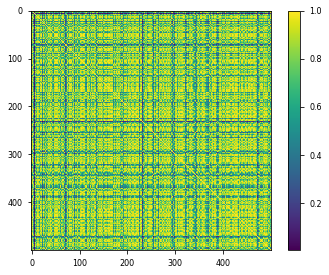

In [6]:
# 2. Exponential Kernel
K_xy = np.exp(-0.5 * dist)

print(K_xy.min(), K_xy.max())

plt.imshow(K_xy)
plt.colorbar()

#### Refactor

Fortunately, there are people smarter than me and they already have a function that does the exact same thing.

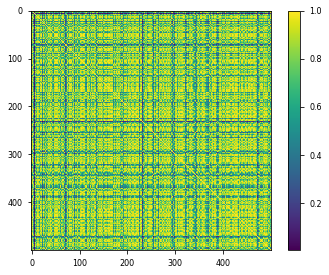

In [7]:
from sklearn.gaussian_process.kernels import RBF



K_sk = RBF(sigma_x)(inputs.X, inputs.X)


plt.imshow(K_sk)
plt.colorbar()

# check that they're the same
np.testing.assert_array_almost_equal(K_xy, K_sk)

#### Side Note - The Original Formula

Most people write down this distance formula:

$$
K(\mathbf{x,y}) = \exp\left(-\frac{\left|\left|\mathbf{x} - \mathbf{y}\right|\right|^2_2}{2\sigma^2}\right)
$$

This is equivalent to the formula I did above:

$$
K(\mathbf{x,y}) =\exp\left(-\frac{\left|\left|\mathbf{x} - \mathbf{y}\right|\right|^2_2}{2\sigma^2}\right) = \exp\left(-\left|\left|\frac{\mathbf{x}}{\sigma} - \frac{\mathbf{y}}{\sigma}\right|\right|^2_2\right)
$$

In [8]:
# original
# 1. Divide each vector by the length scale
X_1d = inputs.X[:, 0].reshape(-1,1)

dist = euclidean_distances(X_1d, X_1d, squared=True)

# 2. Exponential Kernel
K_xy = np.exp(- dist / (2 * sigma_x ** 2))

# quicker
K_sk = RBF(sigma_x)(X_1d, X_1d)

np.testing.assert_array_almost_equal(K_xy, K_sk)

## Calculating HSIC

Calculating HSIC is quite simple.

1. Compute each kernel, $K_x, K_y$
2. Center the Kernel Matrix (or not)
3. Compute the Trace
4. Normalize or not

In [9]:
# kernel matrices
K_x = RBF(sigma_x)(inputs.X)
K_y = RBF(sigma_y)(inputs.Y)

# center the kernel matrices
from sklearn.preprocessing import KernelCenterer

K_xc = KernelCenterer().fit_transform(K_x)
K_yc = KernelCenterer().fit_transform(K_y)

# Compute the Trace
hsic_score = np.sum(K_xc * K_yc)

print('HSIC:', (1 / K_xc.shape[0]**2) * hsic_score)

# normalize by the norm
cka_score = hsic_score / np.linalg.norm(K_xc, ord='fro') / np.linalg.norm(K_yc, ord='fro')

print('CKA:', cka_score)

# Kernel Alignment, no centering
ka_score = np.sum(K_x * K_y) / np.linalg.norm(K_x, ord='fro') / np.linalg.norm(K_y, ord='fro')
print('KA:', ka_score)

HSIC: 0.0002787777096594028
CKA: 0.01807799077138073
KA: 0.9543875481010973


#### Refactor

I already created a more complete function.

In [10]:
from models.dependence import HSICModel

hsic_clf = HSICModel(
    kernel_X=RBF(sigma_x),
    kernel_Y=RBF(sigma_y),
)

# hsic score
hsic_score_ = hsic_clf.get_score(inputs.X, inputs.Y, 'hsic')
print('HSIC:', hsic_score_)

# cka score
cka_score_ = hsic_clf.get_score(inputs.X, inputs.Y, 'cka')
print('HSIC:', cka_score_)

# ka score
ka_score_ = hsic_clf.get_score(inputs.X, inputs.Y, 'ka')
print('HSIC:', ka_score_)

HSIC: 0.0002787777096594028
HSIC: 0.01807799077138073
HSIC: 0.9543875481010973


Notice how the scores are all the same.

## Different Sigma Configurations

So now, let's see how the scores change depending on how we estimate the sigma parameter. We're going to use a combination of the following scenarios:

* HSIC Scorer - HSIC, KA, CKA
* Estimator - Scott, Silverman, Median, Mean, Median Kth (15% samples)
* Sigma Config - Single, Per Dataset, Per Dataset+Dimension

So let's gather all parameter combinations.

In [11]:
parameters = {
    'scorer': ['hsic', 'cka', 'ka'],
    'estimator': [
        ('median', 15),
        ('scott',None),
        ('silverman',None),
        ('median', None),
        ('mean', None),

    ],
    'per_dataset': [True, False],
    'per_dimension': [True, False]
}

And we're going to take the cartesian product so that we get all possible combinations. I have a dedicated function for that.

In [12]:
from experiments.utils import dict_product, run_parallel_step

# create a list of all param combinations
parameters_list = list(dict_product(parameters))
n_params= len(parameters_list)
print('# of Params:', n_params)

# of Params: 60


So we have 60 combinations to look through just from this set of parameters. Now, let's create a look and go through all of the combinations.

In [13]:
results = list()

for iparams in parameters_list:
    
    # 0. Estimate sigma
    f_x = lambda x: sigma_estimate(
        x, 
        method=iparams['estimator'][0], 
        percent=iparams['estimator'][1], 
        heuristic=False
    )
    
    # ========================
    # Per Dimension
    # ========================
    if iparams['per_dimension']:
        sigma_X = [f_x(ifeature.reshape(-1, 1)) for ifeature in inputs.X.T]
        sigma_Y = [f_x(ifeature.reshape(-1, 1)) for ifeature in inputs.Y.T]

    else:
        sigma_X = f_x(inputs.X)
        sigma_Y = f_x(inputs.Y)
    
    # =========================
    # Per Dataset
    # =========================
    if not iparams['per_dataset']:
        sigma_X = np.mean([sigma_X, sigma_Y])
        sigma_Y = np.copy(sigma_X)
    
    # =========================
    # Estimate HSIC
    # =========================
    hsic_clf = HSICModel(
        kernel_X=RBF(sigma_X),
        kernel_Y=RBF(sigma_Y),
    )
    
    score = hsic_clf.get_score(inputs.X, inputs.Y, iparams['scorer'])
    
    # Save Data
    results.append(pd.DataFrame({
        'score': [score],
        'scorer': [iparams['scorer']],
        'estimator': [iparams['estimator']],
        'sigma_Y': [sigma_Y],
        'sigma_X': [sigma_X],
        'per_dimension': [iparams['per_dimension']],
        'per_dataset': [iparams['per_dataset']],
    }))

In [14]:
results_df = pd.concat(results)
results_df

,score,scorer,estimator,sigma_Y,sigma_X,per_dimension,per_dataset
0,0.001993,hsic,"(median, 15)","[0.05111714688849182, 0.051362071720277146]","[0.04721265098560398, 0.0582261233599152]",True,True
0,0.001777,hsic,"(median, 15)",0.618971,0.566652,False,True
0,0.001993,hsic,"(median, 15)",0.051979498238572036,0.0519795,True,False
0,0.001768,hsic,"(median, 15)",0.5928113701712288,0.592811,False,False
0,0.001885,hsic,"(scott, None)","[0.2885399811814427, 0.2885399811814427]","[0.2885399811814427, 0.2885399811814427]",True,True
0,0.001836,hsic,"(scott, None)",0.354954,0.354954,False,True
0,0.001885,hsic,"(scott, None)",0.2885399811814427,0.28854,True,False
0,0.001836,hsic,"(scott, None)",0.35495366597555705,0.354954,False,False
0,0.001871,hsic,"(silverman, None)","[0.30562842716315974, 0.30562842716315974]","[0.30562842716315974, 0.30562842716315974]",True,True
0,0.001836,hsic,"(silverman, None)",0.354954,0.354954,False,True


Evaluating how this all works is very difficult without any plots. So we'll skip ahead to the analysis code review in the next notebook.